In [1]:
import sys
sys.path.append('../../')

from MLTools.src.utils import load_data
import MLTools.src.ftengine as fe
df_train, df_test, df = load_data()

Train dataset has 1460 rows and 80 columns.
Test dataset has 1459 rows and 79 columns.


In [2]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN


In [3]:
df = fe.impute(
    df = df,
    cols = ['LotFrontage'],
    type = 'mean'
)

In [5]:
fe.local_outlier_factor(
    df = df,
    cols = ['LotFrontage']
)[['LotFrontage', 'LotFrontage_outlier']]

,LotFrontage,LotFrontage_outlier
Id,,
1,65.0,False
2,80.0,False
3,68.0,False
4,60.0,False
5,84.0,True
...,...,...
2915,21.0,False
2916,21.0,False
2917,160.0,True


## Visualizing Cross Validation

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold


def plot_cross_val(n_splits: int, splitter_func, df: pd.DataFrame, target_column: str, title_text: str) -> None:
    """Function to plot the cross-validation of various sklearn splitter objects."""
    split = 1
    plot_data = []
    
    if splitter_func == StratifiedKFold:
        y = df[target_column]
        X = df.drop(columns=[target_column])
        for train_index, valid_index in splitter_func(n_splits=n_splits).split(X, y):
            plot_data.append([train_index, 'Train', f'{split}'])
            plot_data.append([valid_index, 'Test', f'{split}'])
            split += 1
    else:
        for train_index, valid_index in splitter_func(n_splits=n_splits).split(df):
            plot_data.append([train_index, 'Train', f'{split}'])
            plot_data.append([valid_index, 'Test', f'{split}'])
            split += 1

    plot_df = pd.DataFrame(plot_data, columns=['Index', 'Dataset', 'Split']).explode('Index')

    plt.figure(figsize=(10, 6))
    handles = []
    labels = []
    
    train_handles = plt.scatter([], [], label='Train', color='blue', alpha=0.7)
    test_handles = plt.scatter([], [], label='Test', color='goldenrod', alpha=0.7)
    
    for split_num, group in plot_df.groupby('Split'):
        train_indices = group['Index'][group['Dataset'] == 'Train']
        test_indices = group['Index'][group['Dataset'] == 'Test']

        plt.scatter(train_indices, [split_num] * len(train_indices), color='blue', alpha=0.7)
        plt.scatter(test_indices, [split_num] * len(test_indices), color='goldenrod', alpha=0.7)
    
    handles.extend([train_handles, test_handles])
    labels.extend(['Train', 'Test'])

    plt.xlabel('Index')
    plt.ylabel('Split')
    plt.title(title_text)
    plt.legend(handles, labels)
    plt.grid(True)
    plt.show()

In [12]:
df = pd.DataFrame(np.random.randn(100, 4), columns=['A', 'B', 'C', 'D'])
df['Target'] = np.random.randint(0, 2, 100)  # Adding a 'Target' column with random binary values
n_splits = 5

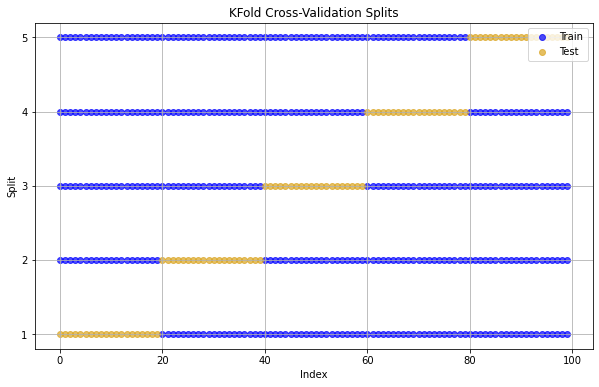

In [13]:
plot_cross_val(n_splits, KFold, df, 'KFold Cross-Validation Splits')

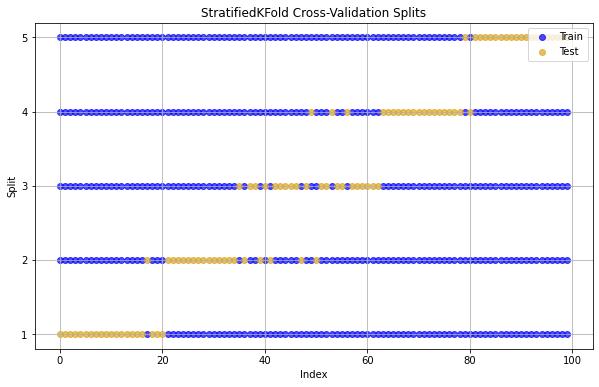

In [16]:
plot_cross_val(n_splits, StratifiedKFold, df, 'Target', 'StratifiedKFold Cross-Validation Splits')

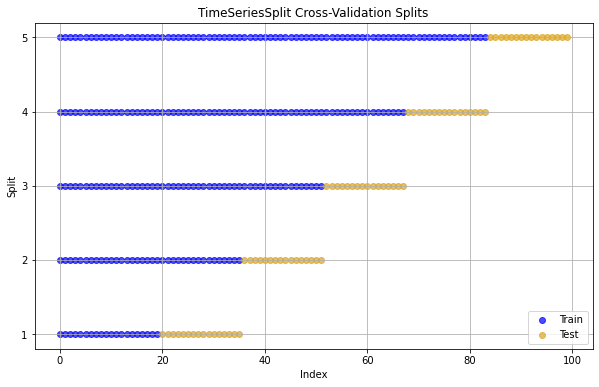

In [17]:
from sklearn.model_selection import TimeSeriesSplit

np.random.seed(42)
date_range = pd.date_range('2022-01-01', periods=100, freq='D')
data = {
    'Date': date_range,
    'Feature_A': np.random.randn(100),
    'Feature_B': np.random.randn(100),
    'Target': np.random.randint(0, 2, 100)
}
df = pd.DataFrame(data)

n_splits = 5
plot_cross_val(n_splits, TimeSeriesSplit, df, 'Target', 'TimeSeriesSplit Cross-Validation Splits')